# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
farthest_point = manager.Value("s", "test")

# Non shared resources
filename = 'casa-coreset'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    farthest_data = farthest_point.value
    if farthest_data is not None:
        X_pool.append(farthest_data)
        
    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool,
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

        embeddings = np.array(list(aspect_outputs.values()))
        distance_matrix = pairwise_distances(embeddings)
        selected_indices = distance_matrix.shape[0] - 1 if farthest_data is not None else 0

        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point.value = aspect_dataset[sorted_dist[0]]['ori_text']

        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        end_time = time.time() 
        duration = end_time - start_time

        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
        
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    # for i in range(1):
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            farthest_point,
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6756, Accuracy: 0.7731, F1 Micro: 0.8711, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5958, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5785, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.513, Accuracy: 0.7939, F1 Micro: 0.8843, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.5006, Accuracy: 0.7924, F1 Micro: 0.8829, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4695, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4328, Accuracy: 0.7969, F1 Micro: 0.8857, F1 Macro: 0.8842
Epoch 8/10, Train Loss: 0.4369, Accuracy: 0.7932, F1 Micro: 0.8832, F1 Macro: 0.8812
Epoch 9/10, Train Loss: 0.415, Accuracy: 0.7917, F1 Micro: 0.8816, F1 Macro: 0.8789
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7162, Accuracy: 0.2857, F1 Micro: 0.2857, F1 Macro: 0.2222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6764, Accuracy: 0.5, F1 Micro: 0.5, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6621, Accuracy: 0.7143, F1 Micro: 0.7143, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.6053, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5803, Accuracy: 0.7857, F1 Micro: 0.7857, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5674, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4789, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4895, Accuracy: 0.8571, F1 Micro: 0.8571, F1 Macro: 0.825
Epoch 9/10, Train Loss: 0.4054, Accuracy: 0.7143, F1 Micro: 0.7143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6434, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5617, Accuracy: 0.8013, F1 Micro: 0.8877, F1 Macro: 0.8861
Epoch 3/10, Train Loss: 0.5271, Accuracy: 0.7939, F1 Micro: 0.8844, F1 Macro: 0.8829
Epoch 4/10, Train Loss: 0.4906, Accuracy: 0.7954, F1 Micro: 0.8851, F1 Macro: 0.8835
Epoch 5/10, Train Loss: 0.457, Accuracy: 0.7991, F1 Micro: 0.8859, F1 Macro: 0.884
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4262, Accuracy: 0.8028, F1 Micro: 0.8885, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4069, Accuracy: 0.8222, F1 Micro: 0.8968, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3631, Accuracy: 0.8385, F1 Micro: 0.9053, F1 Macro: 0.9032
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3127, Accuracy: 0.8661, F1 Micro: 0.9204, F1 Macro: 0.9184
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5818, Accuracy: 0.7381, F1 Micro: 0.7381, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4505, Accuracy: 0.7381, F1 Micro: 0.7381, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3807, Accuracy: 0.7571, F1 Micro: 0.7571, F1 Macro: 0.5109
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2778, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2564, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9157
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1753, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9175
Epoch 7/10, Train Loss: 0.1665, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.897
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1042, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9127
Epoch 9/10, Train Loss: 0.1483, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9121
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6182, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.54, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4892, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.463, Accuracy: 0.8103, F1 Micro: 0.8917, F1 Macro: 0.8905
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4277, Accuracy: 0.8341, F1 Micro: 0.9044, F1 Macro: 0.9035
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.368, Accuracy: 0.8839, F1 Micro: 0.9309, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3155, Accuracy: 0.9115, F1 Micro: 0.9458, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2558, Accuracy: 0.9256, F1 Micro: 0.9539, F1 Macro: 0.9518
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.616, Accuracy: 0.6929, F1 Micro: 0.6929, F1 Macro: 0.4093
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5164, Accuracy: 0.748, F1 Micro: 0.748, F1 Macro: 0.6816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4152, Accuracy: 0.7598, F1 Micro: 0.7598, F1 Macro: 0.7489
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2975, Accuracy: 0.878, F1 Micro: 0.878, F1 Macro: 0.8591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3045, Accuracy: 0.8819, F1 Micro: 0.8819, F1 Macro: 0.8681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2265, Accuracy: 0.8819, F1 Micro: 0.8819, F1 Macro: 0.8622
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2087, Accuracy: 0.8858, F1 Micro: 0.8858, F1 Macro: 0.8663
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.8701, F1 Micro: 0.8701, F1 Macro: 0.8562
Epoch 9/10, Train Loss: 0.1622, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.853
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6038, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5153, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4942, Accuracy: 0.7969, F1 Micro: 0.8859, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4571, Accuracy: 0.8244, F1 Micro: 0.8984, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3741, Accuracy: 0.8921, F1 Micro: 0.9347, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2996, Accuracy: 0.9196, F1 Micro: 0.95, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2424, Accuracy: 0.9256, F1 Micro: 0.9537, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1985, Accuracy: 0.9278, F1 Micro: 0.9552, F1 Macro: 0.9525
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.572, Accuracy: 0.6777, F1 Micro: 0.6777, F1 Macro: 0.4039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4231, Accuracy: 0.8554, F1 Micro: 0.8554, F1 Macro: 0.8316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.25, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1845, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8881
Epoch 5/10, Train Loss: 0.2062, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1324, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1019, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8979
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8887
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5845, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Epoch 2/10, Train Loss: 0.5161, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4739, Accuracy: 0.8095, F1 Micro: 0.8921, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4056, Accuracy: 0.8847, F1 Micro: 0.931, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3137, Accuracy: 0.9271, F1 Micro: 0.9553, F1 Macro: 0.9538
Epoch 6/10, Train Loss: 0.2466, Accuracy: 0.9211, F1 Micro: 0.9506, F1 Macro: 0.9463
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1982, Accuracy: 0.9487, F1 Micro: 0.9681, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1457, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Epoch 9/10, Train Loss: 0.1256, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9704
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.563, Accuracy: 0.6786, F1 Micro: 0.6786, F1 Macro: 0.4043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4059, Accuracy: 0.8849, F1 Micro: 0.8849, F1 Macro: 0.8649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2422, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1934, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8947
Epoch 6/10, Train Loss: 0.1463, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1209, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.9012
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8929
Epoch 9/10, Train Loss: 0.1195, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8947
Epoch 10/10, Train Loss: 0.0825, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5699, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5004, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4453, Accuracy: 0.8259, F1 Micro: 0.9004, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3519, Accuracy: 0.9211, F1 Micro: 0.9513, F1 Macro: 0.9495
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.27, Accuracy: 0.9338, F1 Micro: 0.9588, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2068, Accuracy: 0.9472, F1 Micro: 0.967, F1 Macro: 0.9654
Epoch 7/10, Train Loss: 0.1557, Accuracy: 0.9464, F1 Micro: 0.9663, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1251, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9707
Epoch 9/10, Train Loss: 0.1036, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5983, Accuracy: 0.678, F1 Micro: 0.678, F1 Macro: 0.4041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.377, Accuracy: 0.8712, F1 Micro: 0.8712, F1 Macro: 0.8621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9193
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9241
Epoch 6/10, Train Loss: 0.1307, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.908
Epoch 7/10, Train Loss: 0.1227, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9087
Epoch 8/10, Train Loss: 0.1217, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9048
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1125, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9326
Epoch 10/10, Train Loss: 0.0894, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5738, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5003, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4353, Accuracy: 0.8609, F1 Micro: 0.9182, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3324, Accuracy: 0.9323, F1 Micro: 0.9582, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2532, Accuracy: 0.9509, F1 Micro: 0.9693, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1766, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9711
Epoch 7/10, Train Loss: 0.1467, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1244, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.094, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5625, Accuracy: 0.7954, F1 Micro: 0.7954, F1 Macro: 0.7292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3453, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2539, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9304
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9253
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9207
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9304
Epoch 7/10, Train Loss: 0.1586, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9266
Epoch 8/10, Train Loss: 0.1368, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8792
Epoch 9/10, Train Loss: 0.09, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225
Epoch 10/10, Train Loss: 0.0617, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9176

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5747, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4994, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4344, Accuracy: 0.881, F1 Micro: 0.9296, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3215, Accuracy: 0.9375, F1 Micro: 0.9611, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.235, Accuracy: 0.9546, F1 Micro: 0.9716, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1669, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9723
Epoch 7/10, Train Loss: 0.1264, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0925, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.57, Accuracy: 0.7893, F1 Micro: 0.7893, F1 Macro: 0.7138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3453, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2002, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2222, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2008, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9348
Epoch 6/10, Train Loss: 0.1458, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9044
Epoch 7/10, Train Loss: 0.1182, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9281
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1059, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9352
Epoch 10/10, Train Loss: 0.0793, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5499, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4911, Accuracy: 0.8192, F1 Micro: 0.897, F1 Macro: 0.8967
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3914, Accuracy: 0.9167, F1 Micro: 0.9493, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2805, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9689
Epoch 5/10, Train Loss: 0.1958, Accuracy: 0.9516, F1 Micro: 0.9697, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1558, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.12, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5325, Accuracy: 0.8294, F1 Micro: 0.8294, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2601, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2297, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9467
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9099
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9343
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9343
Epoch 7/10, Train Loss: 0.1042, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8878
Epoch 8/10, Train Loss: 0.1086, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9332
Epoch 9/10, Train Loss: 0.0947, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9264
Epoch 10/10, Train Loss: 0.0629, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8993

Sentiment analysis accuracy: 0.9524, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5603, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4787, Accuracy: 0.8088, F1 Micro: 0.8919, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3917, Accuracy: 0.9152, F1 Micro: 0.9478, F1 Macro: 0.9459
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2852, Accuracy: 0.936, F1 Micro: 0.9599, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2012, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9713
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.122, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9554, F1 Micro: 0.9718, F1 Macro: 0.9696
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5011, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9189
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9153
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.9028
Epoch 6/10, Train Loss: 0.1439, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8915
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8915
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8989
Epoch 9/10, Train Loss: 0.0947, Accuracy: 0.8764, F1 Micro: 0.8764, F1 Macro: 0.8687
Epoch 10/10, Train Loss: 0.0915, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9068

Sentiment analysis accuracy: 0.9266, F1 Micro: 0.9266

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5479, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4701, Accuracy: 0.8311, F1 Micro: 0.9031, F1 Macro: 0.9023
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3713, Accuracy: 0.9308, F1 Micro: 0.9574, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2557, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9699
Epoch 5/10, Train Loss: 0.1855, Accuracy: 0.9494, F1 Micro: 0.968, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1156, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0931, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.076, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5133, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2894, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9168
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9162
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9322
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9004
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9241
Epoch 7/10, Train Loss: 0.1214, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9004
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9173
Epoch 9/10, Train Loss: 0.0927, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9229
Epoch 10/10, Train Loss: 0.0842, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9197

Sentiment analysis accuracy: 0.9394, F1 Micro: 0.9394, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5433, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4723, Accuracy: 0.817, F1 Micro: 0.8959, F1 Macro: 0.8949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.36, Accuracy: 0.9412, F1 Micro: 0.9636, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2425, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1817, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.1034, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9781
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9767
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.52, Accuracy: 0.874, F1 Micro: 0.874, F1 Macro: 0.8449
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2286, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1692, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9063
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1497, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9179
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9327
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9308
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9147
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5596, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4745, Accuracy: 0.8192, F1 Micro: 0.897, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3462, Accuracy: 0.939, F1 Micro: 0.9624, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2413, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1749, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9754
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.965, F1 Micro: 0.9778, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5054, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.854
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.181, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9484
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9439
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9391
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.9042
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9398

Sentiment analysis accuracy: 0.9537, F1 Micro: 0.9537,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5367, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4643, Accuracy: 0.8542, F1 Micro: 0.9149, F1 Macro: 0.9145
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3323, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2287, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9738
Epoch 5/10, Train Loss: 0.1603, Accuracy: 0.9539, F1 Micro: 0.971, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5411, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8772
Epoch 2/10, Train Loss: 0.2852, Accuracy: 0.8906, F1 Micro: 0.8906, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1607, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.923
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9275
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9175
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9271
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9356

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5358, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4465, Accuracy: 0.8527, F1 Micro: 0.9144, F1 Macro: 0.9144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3254, Accuracy: 0.9397, F1 Micro: 0.9626, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2088, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9734
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4997, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9154
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9435
Epoch 6/10, Train Loss: 0.1292, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9252
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9507
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9141
Epoch 10/10, Train Loss: 0.0676, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5265, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.431, Accuracy: 0.8943, F1 Micro: 0.9364, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2967, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5311, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.889
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.8846, F1 Micro: 0.8846, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.133, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.944
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9402
Epoch 10/10, Train Loss: 0.0688, Accuracy: 0.9385, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5405, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4294, Accuracy: 0.9234, F1 Micro: 0.9532, F1 Macro: 0.9522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2881, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.198, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1068, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5255, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.219, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.9338, F1 Micro: 0.9338, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9449
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9485, F1 Micro: 0.9485, F1 Macro: 0.9419
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9459
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9187
Epoch 10/10, Train Loss: 0.076, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5308, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4261, Accuracy: 0.9263, F1 Micro: 0.9544, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2807, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1897, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9753
Epoch 5/10, Train Loss: 0.1383, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4749, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2211, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.932
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9178
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9328
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9332
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9244
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0561, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5318, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.42, Accuracy: 0.9196, F1 Micro: 0.9511, F1 Macro: 0.9498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2727, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9813
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5306, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2324, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9353
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9229
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9157
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0589, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5311, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4151, Accuracy: 0.9249, F1 Micro: 0.9542, F1 Macro: 0.953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2706, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9782
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9781
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5174, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2205, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9358
Epoch 3/10, Train Loss: 0.1504, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9239
Epoch 4/10, Train Loss: 0.1316, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9268
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9577, F1 Micro: 0.9577, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9577, F1 Micro: 0.9577, F1 Macro: 0.9524
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9462, F1 Micro: 0.9462, F1 Macro: 0.9399
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9538, F1 Micro: 0.9538, F1 Macro: 0.9476
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.95, F1 Micro: 0.95, F1 Macro: 0.9427

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5316, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4155, Accuracy: 0.9211, F1 Micro: 0.9519, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2665, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4716, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9104
Epoch 2/10, Train Loss: 0.2554, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9367
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9319
Epoch 5/10, Train Loss: 0.1015, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9255
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9334
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9027
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9085
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9159
Epoch 10/10, Train Loss: 0.0495, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.9017

Sentiment analysis accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9367
              

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4177, Accuracy: 0.9196, F1 Micro: 0.9512, F1 Macro: 0.9498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2664, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.178, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9813
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4841, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1446, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9388
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.935
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9251
Epoch 7/10, Train Loss: 0.0892, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9113
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9434
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9246
Epoch 10/10, Train Loss: 0.0841, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.53, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.396, Accuracy: 0.9375, F1 Micro: 0.9614, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2483, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9768
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9745
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9732, F1 Micro: 0.9831, F1 Macro: 0.9822
Epoch 10/10, Train Loss: 0.0457

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4724, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2238, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9288
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9208
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8938
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8998
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9168
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9313
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9164
Epoch 10/10, Train Loss: 0.0569, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.916

Sentiment analysis accuracy: 0.9392, F1 Micro: 0.9392, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5303, Accuracy: 0.8058, F1 Micro: 0.8905, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3796, Accuracy: 0.9234, F1 Micro: 0.9527, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2411, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.98
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.979
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9772
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.968, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4927, Accuracy: 0.8906, F1 Micro: 0.8906, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.244, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Epoch 3/10, Train Loss: 0.1756, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Epoch 4/10, Train Loss: 0.1364, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9274
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.083, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9439
Epoch 10/10, Train Loss: 0.0848, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Ma

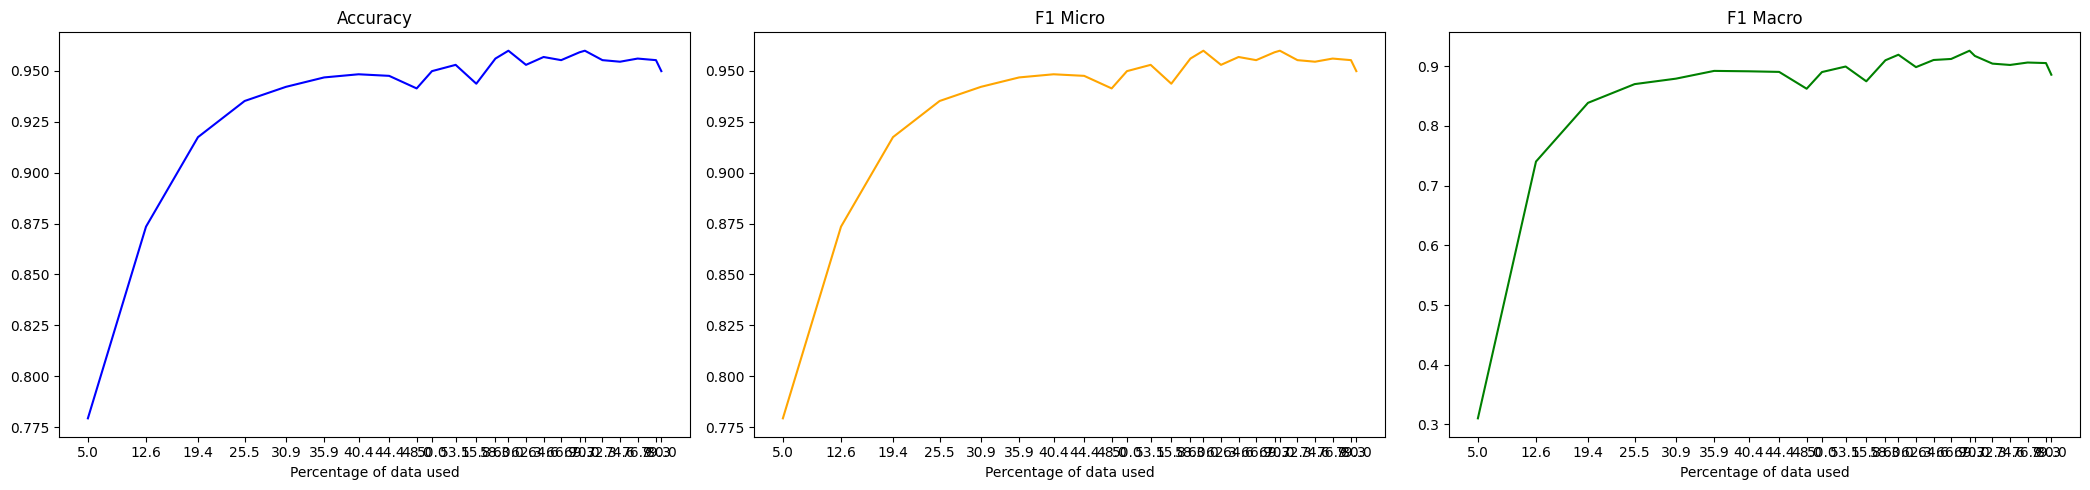

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.7054, F1 Micro: 0.8127, F1 Macro: 0.7262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5731, Accuracy: 0.7374, F1 Micro: 0.8408, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5493, Accuracy: 0.7917, F1 Micro: 0.8824, F1 Macro: 0.8802
Epoch 4/10, Train Loss: 0.5049, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Epoch 5/10, Train Loss: 0.4781, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 6/10, Train Loss: 0.4364, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4061, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 8/10, Train Loss: 0.4421, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4208, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6351, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5577, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5004, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4905, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4593, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4341, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4188, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2323, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6211, Accuracy: 0.7924, F1 Micro: 0.8824, F1 Macro: 0.8801
Epoch 2/10, Train Loss: 0.5161, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 3/10, Train Loss: 0.4789, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4471, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4156, Accuracy: 0.8021, F1 Micro: 0.8885, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4074, Accuracy: 0.8452, F1 Micro: 0.9096, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3404, Accuracy: 0.8772, F1 Micro: 0.926, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2852, Accuracy: 0.8899, F1 Micro: 0.933, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.255, Accuracy: 0.8988, F1 Micro: 0.9377, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6911, Accuracy: 0.6961, F1 Micro: 0.6961, F1 Macro: 0.4104
Epoch 2/10, Train Loss: 0.6505, Accuracy: 0.6912, F1 Micro: 0.6912, F1 Macro: 0.4629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5618, Accuracy: 0.7745, F1 Micro: 0.7745, F1 Macro: 0.7032
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4435, Accuracy: 0.8578, F1 Micro: 0.8578, F1 Macro: 0.8342
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3129, Accuracy: 0.8922, F1 Micro: 0.8922, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1977, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8829
Epoch 7/10, Train Loss: 0.1712, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1513, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.88
Epoch 9/10, Train Loss: 0.1387, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8736
Epoch 10/10, Train Loss: 0.1093, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6059, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5335, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5122, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4655, Accuracy: 0.8341, F1 Micro: 0.9043, F1 Macro: 0.903
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.387, Accuracy: 0.8661, F1 Micro: 0.9203, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3351, Accuracy: 0.8914, F1 Micro: 0.9335, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2958, Accuracy: 0.9055, F1 Micro: 0.9414, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2517, Accuracy: 0.9196, F1 Micro: 0.9499, F1 Macro: 0.9474
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5381, Accuracy: 0.7102, F1 Micro: 0.7102, F1 Macro: 0.4153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5293, Accuracy: 0.7102, F1 Micro: 0.7102, F1 Macro: 0.4153
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3784, Accuracy: 0.7265, F1 Micro: 0.7265, F1 Macro: 0.4726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3624, Accuracy: 0.8367, F1 Micro: 0.8367, F1 Macro: 0.7817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1847, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8785
Epoch 6/10, Train Loss: 0.143, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1279, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8891
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8871
Epoch 9/10, Train Loss: 0.1253, Accuracy: 0.8857, F1 Micro: 0.8857, F1 Macro: 0.8562
Epoch 10/10, Train Loss: 0.0955, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.576, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4926, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4775, Accuracy: 0.808, F1 Micro: 0.8914, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4239, Accuracy: 0.8713, F1 Micro: 0.9239, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3439, Accuracy: 0.904, F1 Micro: 0.9411, F1 Macro: 0.9395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2904, Accuracy: 0.9115, F1 Micro: 0.9453, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2401, Accuracy: 0.9278, F1 Micro: 0.955, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1947, Accuracy: 0.939, F1 Micro: 0.9619, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 9/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6193, Accuracy: 0.6992, F1 Micro: 0.6992, F1 Macro: 0.4363
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4971, Accuracy: 0.7236, F1 Micro: 0.7236, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3173, Accuracy: 0.8659, F1 Micro: 0.8659, F1 Macro: 0.8495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2272, Accuracy: 0.8862, F1 Micro: 0.8862, F1 Macro: 0.8677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.179, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1464, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.9018
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0944, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.9043
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1578, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9128
Epoch 9/10, Train Loss: 0.1241, Accuracy: 0.9146, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5855, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4906, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4526, Accuracy: 0.8408, F1 Micro: 0.9081, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3716, Accuracy: 0.907, F1 Micro: 0.9432, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2931, Accuracy: 0.9293, F1 Micro: 0.9562, F1 Macro: 0.9538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2285, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1914, Accuracy: 0.9501, F1 Micro: 0.9689, F1 Macro: 0.9672
Epoch 8/10, Train Loss: 0.1592, Accuracy: 0.9501, F1 Micro: 0.9686, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1285, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5611, Accuracy: 0.6853, F1 Micro: 0.6853, F1 Macro: 0.4066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4434, Accuracy: 0.8367, F1 Micro: 0.8367, F1 Macro: 0.8126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2518, Accuracy: 0.8446, F1 Micro: 0.8446, F1 Macro: 0.8352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1622, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8948
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8944
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.895
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9131
Epoch 9/10, Train Loss: 0.0798, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.895
Epoch 10/10, Train Loss: 0.0707, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5619, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.507, Accuracy: 0.8051, F1 Micro: 0.8901, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4135, Accuracy: 0.8772, F1 Micro: 0.927, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3256, Accuracy: 0.9234, F1 Micro: 0.9525, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2556, Accuracy: 0.9487, F1 Micro: 0.968, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1996, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9691
Epoch 7/10, Train Loss: 0.1476, Accuracy: 0.9442, F1 Micro: 0.9647, F1 Macro: 0.9612
Epoch 8/10, Train Loss: 0.1308, Accuracy: 0.9472, F1 Micro: 0.9666, F1 Macro: 0.9636
Epoch 9/10, Train Loss: 0.1013, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9683
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5898, Accuracy: 0.6897, F1 Micro: 0.6897, F1 Macro: 0.4082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4797, Accuracy: 0.8467, F1 Micro: 0.8467, F1 Macro: 0.8082
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2814, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9035
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.9022
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9057
Epoch 7/10, Train Loss: 0.1521, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.8631
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1286, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9256
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5713, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4907, Accuracy: 0.8155, F1 Micro: 0.8954, F1 Macro: 0.8943
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4013, Accuracy: 0.9003, F1 Micro: 0.94, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2956, Accuracy: 0.9315, F1 Micro: 0.9574, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2252, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.183, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1399, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9719
Epoch 8/10, Train Loss: 0.1137, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9677
Epoch 9/10, Train Loss: 0.0977, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5921, Accuracy: 0.6773, F1 Micro: 0.6773, F1 Macro: 0.4038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3533, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.9043
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1324, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9074
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9323
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.8924, F1 Micro: 0.8924, F1 Macro: 0.885
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9079
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.9079
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.9243, F1 Micro: 0.9243, F1 Macro: 0.9131
Epoch 10/10, Train Loss: 0.1034, Accuracy: 0.9084, F1 Micro: 0.9084, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5639, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4648, Accuracy: 0.8185, F1 Micro: 0.8969, F1 Macro: 0.896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3805, Accuracy: 0.9048, F1 Micro: 0.9418, F1 Macro: 0.9399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2884, Accuracy: 0.9338, F1 Micro: 0.9587, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2194, Accuracy: 0.9487, F1 Micro: 0.9679, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1631, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9708
Epoch 7/10, Train Loss: 0.13, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9702
Epoch 8/10, Train Loss: 0.1155, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0908, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5559, Accuracy: 0.8353, F1 Micro: 0.8353, F1 Macro: 0.795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2967, Accuracy: 0.8824, F1 Micro: 0.8824, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2146, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9047
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9271
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9256
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9281
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9169
Epoch 9/10, Train Loss: 0.0922, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9256
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0529, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5641, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4637, Accuracy: 0.8534, F1 Micro: 0.9146, F1 Macro: 0.9146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3592, Accuracy: 0.9293, F1 Micro: 0.9565, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2603, Accuracy: 0.9435, F1 Micro: 0.9648, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1959, Accuracy: 0.9449, F1 Micro: 0.9654, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1534, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1197, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9718
Epoch 8/10, Train Loss: 0.0988, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0784, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5883, Accuracy: 0.7273, F1 Micro: 0.7273, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3091, Accuracy: 0.8788, F1 Micro: 0.8788, F1 Macro: 0.8696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9043
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9197
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9043
Epoch 6/10, Train Loss: 0.113, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9113
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9183
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.9265
Epoch 10/10, Train Loss: 0.0973, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5508, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.8445, F1 Micro: 0.9103, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3564, Accuracy: 0.9271, F1 Micro: 0.9553, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2576, Accuracy: 0.9405, F1 Micro: 0.9629, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2006, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9718
Epoch 6/10, Train Loss: 0.1439, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9715
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1047, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.972
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5741, Accuracy: 0.7945, F1 Micro: 0.7945, F1 Macro: 0.7335
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.8458, F1 Micro: 0.8458, F1 Macro: 0.8385
Epoch 3/10, Train Loss: 0.2108, Accuracy: 0.8419, F1 Micro: 0.8419, F1 Macro: 0.8346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9407, F1 Micro: 0.9407, F1 Macro: 0.933
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9289, F1 Micro: 0.9289, F1 Macro: 0.9193
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9249
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.9092
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9245
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9291
Epoch 10/10, Train Loss: 0.0532, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Macro: 0.9146

Sentiment analysis accuracy: 0.9407, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5384, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4572, Accuracy: 0.878, F1 Micro: 0.9278, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3319, Accuracy: 0.9449, F1 Micro: 0.9661, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2378, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1915, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1489, Accuracy: 0.9598, F1 Micro: 0.9746, F1 Macro: 0.9729
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9714
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9561, F1 Micro: 0.9722, F1 Macro: 0.9696
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9726
Higher F1 achieved, s

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5717, Accuracy: 0.7034, F1 Micro: 0.7034, F1 Macro: 0.4862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2908, Accuracy: 0.8631, F1 Micro: 0.8631, F1 Macro: 0.853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8997
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9231
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9155
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9213
Epoch 7/10, Train Loss: 0.1291, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9151
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9305
Epoch 10/10, Train Loss: 0.0698, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5486, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4511, Accuracy: 0.8802, F1 Micro: 0.9292, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3273, Accuracy: 0.9382, F1 Micro: 0.9615, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2279, Accuracy: 0.9531, F1 Micro: 0.9708, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1771, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1328, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0781, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5525, Accuracy: 0.8566, F1 Micro: 0.8566, F1 Macro: 0.8344
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2993, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9114
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9089
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9159
Epoch 6/10, Train Loss: 0.1587, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8972
Epoch 7/10, Train Loss: 0.1217, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9124
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.9011
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.104, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0684, Accuracy: 0.9245, F1 Micro: 0.9245, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5473, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4421, Accuracy: 0.8854, F1 Micro: 0.9318, F1 Macro: 0.9311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.312, Accuracy: 0.9435, F1 Micro: 0.965, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2188, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1678, Accuracy: 0.9568, F1 Micro: 0.9728, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1446, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5337, Accuracy: 0.8447, F1 Micro: 0.8447, F1 Macro: 0.8113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.178, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1297, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9486
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9444
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.087, Accuracy: 0.9545, F1 Micro: 0.9545, F1 Macro: 0.9489
Epoch 8/10, Train Loss: 0.0996, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9306
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9396
Epoch 10/10, Train Loss: 0.0942, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5456, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4263, Accuracy: 0.901, F1 Micro: 0.9403, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2973, Accuracy: 0.9472, F1 Micro: 0.9673, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1976, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9763
Epoch 6/10, Train Loss: 0.1234, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5172, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.9485, F1 Micro: 0.9485, F1 Macro: 0.9419
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9485, F1 Micro: 0.9485, F1 Macro: 0.9422
Epoch 5/10, Train Loss: 0.1363, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9382
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9372
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9462
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9522, F1 Micro: 0.9522, F1 Macro: 0.9446
Epoch 10/10, Train Loss: 0.05, Accuracy: 0.9449, F1 Micro: 0.9449, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5416, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.41, Accuracy: 0.9152, F1 Micro: 0.9478, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2813, Accuracy: 0.9464, F1 Micro: 0.9668, F1 Macro: 0.9652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2017, Accuracy: 0.9591, F1 Micro: 0.9746, F1 Macro: 0.9734
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Epoch 10/10, Train Loss: 0.0531, Accuracy: 0.9658, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5024, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9623, F1 Micro: 0.9623, F1 Macro: 0.9577
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.9477
Epoch 5/10, Train Loss: 0.0911, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.949
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9547, F1 Micro: 0.9547, F1 Macro: 0.9484
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9411
Epoch 10/10, Train Loss: 0.0643, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9452

Sentiment analysis accuracy: 0.9623, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5374, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4255, Accuracy: 0.9107, F1 Micro: 0.9448, F1 Macro: 0.9425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2924, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9598, F1 Micro: 0.9751, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5244, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.943
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9271
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9189
Epoch 6/10, Train Loss: 0.1313, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9473
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0953, Accuracy: 0.965, F1 Micro: 0.965, F1 Macro: 0.9598
Epoch 9/10, Train Loss: 0.0654, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9388
Epoch 10/10, Train Loss: 0.0744, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5319, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3995, Accuracy: 0.9137, F1 Micro: 0.947, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2699, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9782
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.48, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.9005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2457, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9569, F1 Micro: 0.9569, F1 Macro: 0.9524
Epoch 4/10, Train Loss: 0.1039, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9238
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9647, F1 Micro: 0.9647, F1 Macro: 0.9611
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9485
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9485
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9529, F1 Micro: 0.9529, F1 Macro: 0.9485
Epoch 10/10, Train Loss: 0.0506, Accuracy: 0.9608, F1 Micro: 0.9608, F1 Macro: 0.9568

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5258, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4093, Accuracy: 0.9077, F1 Micro: 0.9433, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2718, Accuracy: 0.9509, F1 Micro: 0.9696, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.513, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.228, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9301
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9364
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9482
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9275
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9427
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9385
Epoch 10/10, Train Loss: 0.0713, Accuracy: 0.9261, F1 Micro: 0.9261, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5276, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4066, Accuracy: 0.9211, F1 Micro: 0.9515, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2696, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1934, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0577, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.536, Accuracy: 0.883, F1 Micro: 0.883, F1 Macro: 0.8653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2398, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1855, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9337
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9417
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9457
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9414
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9623, F1 Micro: 0.9623, F1 Macro: 0.9577
Epoch 9/10, Train Loss: 0.0767, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.936
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5271, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.383, Accuracy: 0.9293, F1 Micro: 0.956, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2571, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9746
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9715
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4883, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2223, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1595, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9091
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.957, F1 Micro: 0.957, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.957, F1 Micro: 0.957, F1 Macro: 0.9523
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9481
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.957, F1 Micro: 0.957, F1 Macro: 0.9523
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5247, Accuracy: 0.8021, F1 Micro: 0.8886, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3851, Accuracy: 0.9286, F1 Micro: 0.9556, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2553, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.18, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9794
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9791
Epoch 9/10, Train Loss: 0.052, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5255, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2494, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9414
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9283
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9323
Epoch 5/10, Train Loss: 0.0857, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9374
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9585, F1 Micro: 0.9585, F1 Macro: 0.9531
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9367
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371
Epoch 10/10, Train Loss: 0.0432, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371

Sentiment analysis accuracy: 0.9585, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5262, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3841, Accuracy: 0.9241, F1 Micro: 0.953, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2527, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9794
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9786
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5294, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.9043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1059, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9378
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9357, F1 Micro: 0.9357, F1 Macro: 0.9293
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9339
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9371
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.9382
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.517, Accuracy: 0.8065, F1 Micro: 0.8908, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3706, Accuracy: 0.9382, F1 Micro: 0.9614, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2338, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.9811
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9762
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9764
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4898, Accuracy: 0.8859, F1 Micro: 0.8859, F1 Macro: 0.8785
Epoch 2/10, Train Loss: 0.2792, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1615, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 5/10, Train Loss: 0.1055, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9137
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9295
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9172
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9227
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0587, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9372

Sentiment analysis accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5195, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3608, Accuracy: 0.9308, F1 Micro: 0.9571, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.236, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9688, F1 Micro: 0.9802, F1 Macro: 0.9787
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5023, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9114
Epoch 2/10, Train Loss: 0.2169, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1555, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.936
Epoch 4/10, Train Loss: 0.1355, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9177
Epoch 5/10, Train Loss: 0.095, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9256
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9259
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9184
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9255
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9149
Epoch 10/10, Train Loss: 0.0627, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9216

Sentiment analysis accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.936
              prec

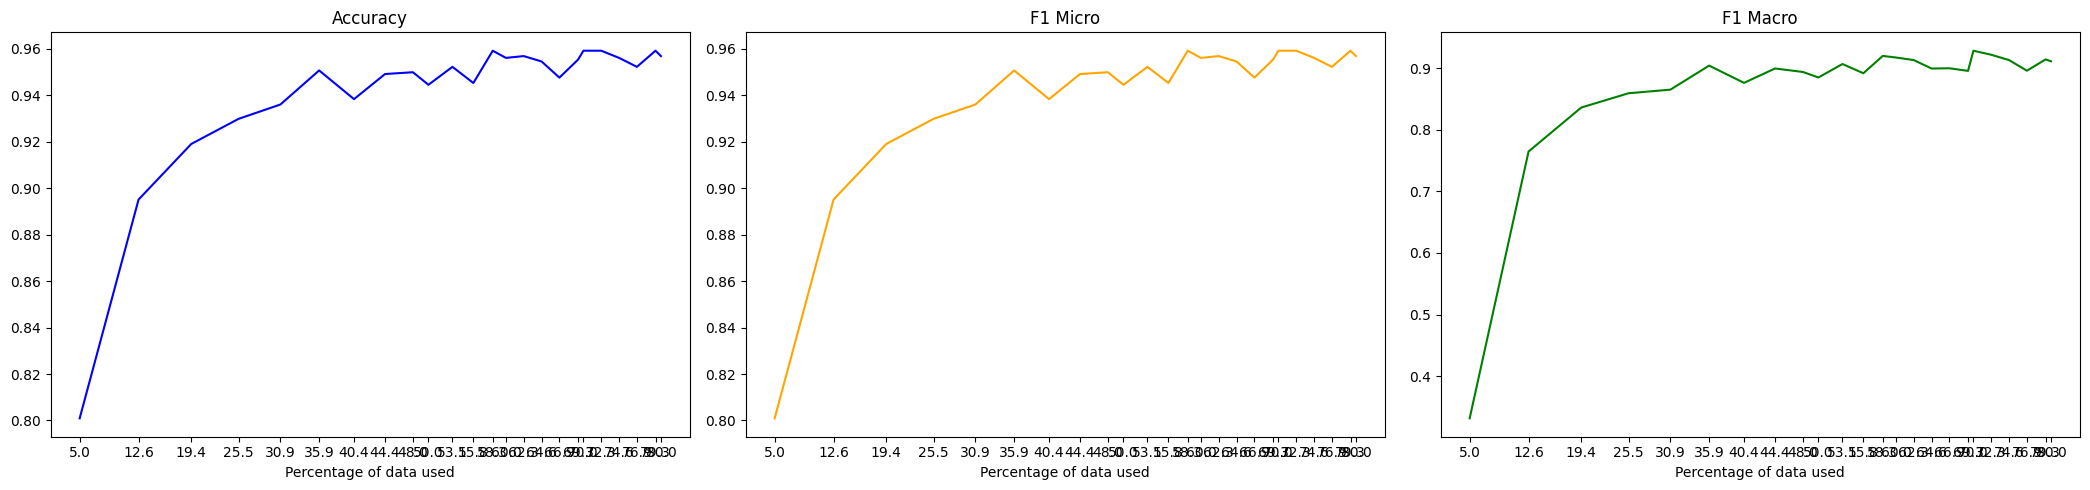

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6791, Accuracy: 0.7746, F1 Micro: 0.8722, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5752, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.512, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4609, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4127, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3898, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4151, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.8159, Accuracy: 0.3333, F1 Micro: 0.3333, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6264, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5442, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5154, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4038, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3617, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3192, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2942, Accuracy: 0.6667, F1 Micro: 0.6667, F1 Macro: 0.4
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3391, Accuracy: 0.66

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.624, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4937, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.491, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4548, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4271, Accuracy: 0.7961, F1 Micro: 0.8855, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3768, Accuracy: 0.8028, F1 Micro: 0.8883, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3466, Accuracy: 0.8445, F1 Micro: 0.9092, F1 Macro: 0.9077
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2986, Accuracy: 0.8683, F1 Micro: 0.9219, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.665, Accuracy: 0.676, F1 Micro: 0.676, F1 Macro: 0.4033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6114, Accuracy: 0.6927, F1 Micro: 0.6927, F1 Macro: 0.4566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.561, Accuracy: 0.7207, F1 Micro: 0.7207, F1 Macro: 0.5654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5134, Accuracy: 0.8212, F1 Micro: 0.8212, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4102, Accuracy: 0.8883, F1 Micro: 0.8883, F1 Macro: 0.8688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3159, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2019, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.889
Epoch 8/10, Train Loss: 0.1706, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8831
Epoch 9/10, Train Loss: 0.1707, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8807
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6065, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5179, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5036, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4734, Accuracy: 0.8036, F1 Micro: 0.8892, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4309, Accuracy: 0.8177, F1 Micro: 0.8949, F1 Macro: 0.893
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3432, Accuracy: 0.8542, F1 Micro: 0.9127, F1 Macro: 0.9096
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3135, Accuracy: 0.8936, F1 Micro: 0.935, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2625, Accuracy: 0.9092, F1 Micro: 0.9444, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5792, Accuracy: 0.6947, F1 Micro: 0.6947, F1 Macro: 0.4099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4216, Accuracy: 0.6947, F1 Micro: 0.6947, F1 Macro: 0.4099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3337, Accuracy: 0.8451, F1 Micro: 0.8451, F1 Macro: 0.7982
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2261, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8918
Epoch 6/10, Train Loss: 0.128, Accuracy: 0.8938, F1 Micro: 0.8938, F1 Macro: 0.8738
Epoch 7/10, Train Loss: 0.1296, Accuracy: 0.885, F1 Micro: 0.885, F1 Macro: 0.8569
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8764
Epoch 9/10, Train Loss: 0.0916, Accuracy: 0.8938, F1 Micro: 0.8938, F1 Macro: 0.8727
Epoch 10/10, Train Loss: 0.0597, Accuracy: 0.885, F1 Micro: 0.885, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5964, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4979, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4847, Accuracy: 0.7984, F1 Micro: 0.8867, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4199, Accuracy: 0.8289, F1 Micro: 0.9001, F1 Macro: 0.8979
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.356, Accuracy: 0.8757, F1 Micro: 0.9251, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2886, Accuracy: 0.9129, F1 Micro: 0.946, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2408, Accuracy: 0.9278, F1 Micro: 0.9552, F1 Macro: 0.9526
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1896, Accuracy: 0.9368, F1 Micro: 0.9606, F1 Macro: 0.9582
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5565, Accuracy: 0.7449, F1 Micro: 0.7449, F1 Macro: 0.6776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4151, Accuracy: 0.8519, F1 Micro: 0.8519, F1 Macro: 0.8333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2812, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2309, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.908
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1845, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.9043
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.9042
Epoch 7/10, Train Loss: 0.141, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.9025
Epoch 8/10, Train Loss: 0.1598, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8938
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1302, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.9074
Epoch 10/10, Train Loss: 0.1159, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5747, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4925, Accuracy: 0.7917, F1 Micro: 0.8833, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4558, Accuracy: 0.8147, F1 Micro: 0.8935, F1 Macro: 0.8913
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3822, Accuracy: 0.875, F1 Micro: 0.9244, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3108, Accuracy: 0.9048, F1 Micro: 0.9413, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2403, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1859, Accuracy: 0.939, F1 Micro: 0.9619, F1 Macro: 0.9597
Epoch 8/10, Train Loss: 0.152, Accuracy: 0.939, F1 Micro: 0.9615, F1 Macro: 0.9581
Epoch 9/10, Train Loss: 0.1232, Accuracy: 0.9301, F1 Micro: 0.9558, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5779, Accuracy: 0.6749, F1 Micro: 0.6749, F1 Macro: 0.4029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3653, Accuracy: 0.8807, F1 Micro: 0.8807, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2394, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8936
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.137, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9229
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9215
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8931
Epoch 8/10, Train Loss: 0.1184, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9161
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.8971, F1 Micro: 0.8971, F1 Macro: 0.8761
Epoch 10/10, Train Loss: 0.0794, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5535, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.488, Accuracy: 0.7999, F1 Micro: 0.8875, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4226, Accuracy: 0.8259, F1 Micro: 0.8979, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3509, Accuracy: 0.9033, F1 Micro: 0.9403, F1 Macro: 0.9373
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2549, Accuracy: 0.9375, F1 Micro: 0.9612, F1 Macro: 0.9596
Epoch 6/10, Train Loss: 0.1947, Accuracy: 0.936, F1 Micro: 0.9598, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.152, Accuracy: 0.942, F1 Micro: 0.9632, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1121, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9672
Epoch 9/10, Train Loss: 0.0989, Accuracy: 0.9509, F1 Micro: 0.969, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5692, Accuracy: 0.8386, F1 Micro: 0.8386, F1 Macro: 0.8182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3537, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.9044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2055, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9126
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1222, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9136
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1025, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9213
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5465, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.483, Accuracy: 0.8021, F1 Micro: 0.8886, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4272, Accuracy: 0.8542, F1 Micro: 0.9134, F1 Macro: 0.911
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3314, Accuracy: 0.9137, F1 Micro: 0.9462, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2484, Accuracy: 0.9397, F1 Micro: 0.9623, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1914, Accuracy: 0.9479, F1 Micro: 0.9675, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1524, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9709
Epoch 8/10, Train Loss: 0.1132, Accuracy: 0.9479, F1 Micro: 0.967, F1 Macro: 0.9636
Epoch 9/10, Train Loss: 0.0972, Accuracy: 0.9546, F1 Micro: 0.9713, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5657, Accuracy: 0.821, F1 Micro: 0.821, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3212, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8736
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.8599, F1 Micro: 0.8599, F1 Macro: 0.8497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9204
Epoch 5/10, Train Loss: 0.1569, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.877
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8953
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9039
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9172
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9141
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0701, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9204

Se

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.562, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.485, Accuracy: 0.8058, F1 Micro: 0.8905, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4114, Accuracy: 0.8571, F1 Micro: 0.9125, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3068, Accuracy: 0.9249, F1 Micro: 0.9531, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2165, Accuracy: 0.942, F1 Micro: 0.964, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1784, Accuracy: 0.9449, F1 Micro: 0.9656, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1307, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.9681
Epoch 8/10, Train Loss: 0.1078, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0906, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5626, Accuracy: 0.8071, F1 Micro: 0.8071, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2761, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9069
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9195
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9237
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.9126
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1139, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9275
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9377
Epoch 10/10, Train Loss: 0.0536, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5456, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4733, Accuracy: 0.8147, F1 Micro: 0.8937, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3808, Accuracy: 0.8958, F1 Micro: 0.936, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2702, Accuracy: 0.9338, F1 Micro: 0.9586, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1966, Accuracy: 0.9442, F1 Micro: 0.9651, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1484, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9742
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9713
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9695
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.972
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5433, Accuracy: 0.8664, F1 Micro: 0.8664, F1 Macro: 0.8414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2871, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1722, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1291, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0781, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9514, F1 Micro: 0.9514, F1 Macro: 0.9452
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9408
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9514, F1 Micro: 0.9514, F1 Macro: 0.9445
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5481, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4598, Accuracy: 0.8147, F1 Micro: 0.8926, F1 Macro: 0.8899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3711, Accuracy: 0.8988, F1 Micro: 0.9373, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2713, Accuracy: 0.9382, F1 Micro: 0.9613, F1 Macro: 0.9597
Epoch 5/10, Train Loss: 0.2031, Accuracy: 0.936, F1 Micro: 0.9595, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1486, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5571, Accuracy: 0.88, F1 Micro: 0.88, F1 Macro: 0.8663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2589, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9383
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9095
Epoch 4/10, Train Loss: 0.1282, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9095
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9465
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9405
Epoch 10/10, Train Loss: 0.066, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9361

Sentime

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5366, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4634, Accuracy: 0.8207, F1 Micro: 0.8964, F1 Macro: 0.8946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.373, Accuracy: 0.904, F1 Micro: 0.94, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2663, Accuracy: 0.9427, F1 Micro: 0.9641, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1995, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1488, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Epoch 7/10, Train Loss: 0.1169, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9703
Epoch 8/10, Train Loss: 0.0985, Accuracy: 0.9576, F1 Micro: 0.9732, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5369, Accuracy: 0.8828, F1 Micro: 0.8828, F1 Macro: 0.8715
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.8789, F1 Micro: 0.8789, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.132, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1532, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1363, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9175
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9093
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.9031
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0833, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5454, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4536, Accuracy: 0.8251, F1 Micro: 0.8988, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3422, Accuracy: 0.9278, F1 Micro: 0.9556, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2394, Accuracy: 0.9501, F1 Micro: 0.9688, F1 Macro: 0.9671
Epoch 5/10, Train Loss: 0.1726, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9554, F1 Micro: 0.9719, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4984, Accuracy: 0.8906, F1 Micro: 0.8906, F1 Macro: 0.8818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2587, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.93
Epoch 3/10, Train Loss: 0.1661, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1225, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9387
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8991
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9139
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9212
Epoch 8/10, Train Loss: 0.0724, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9433
Epoch 10/10, Train Loss: 0.0463, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9249

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.448, Accuracy: 0.8244, F1 Micro: 0.8982, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3288, Accuracy: 0.9226, F1 Micro: 0.9518, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2343, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0998, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0617, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5247, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9353
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1302, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9241
Epoch 6/10, Train Loss: 0.1446, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9366
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9312
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0.9459, F1 Micro: 0.9459, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5379, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.441, Accuracy: 0.846, F1 Micro: 0.9089, F1 Macro: 0.9068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3227, Accuracy: 0.9301, F1 Micro: 0.9566, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2167, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.156, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9726
Epoch 6/10, Train Loss: 0.1127, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9732
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5314, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2838, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.173, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9326
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.13, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9445
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9391
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9315
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9353
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0812, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9445
Epoch 10/10, Train Loss: 0.0582, Accuracy: 0.9421, F1 Micro: 0.9421, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.533, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4261, Accuracy: 0.8631, F1 Micro: 0.9184, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2923, Accuracy: 0.9353, F1 Micro: 0.9597, F1 Macro: 0.9577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2008, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0576, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5146, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.8677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9274
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8808
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9201
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9308
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0555, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9398
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0682, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5263, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4495, Accuracy: 0.8668, F1 Micro: 0.9203, F1 Macro: 0.9178
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3115, Accuracy: 0.9427, F1 Micro: 0.9646, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2164, Accuracy: 0.9554, F1 Micro: 0.9721, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.9781
Epoch 9/10, Train Loss: 0.0662, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5093, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.231, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9504
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1041, Accuracy: 0.9593, F1 Micro: 0.9593, F1 Macro: 0.9551
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9421
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9472, F1 Micro: 0.9472, F1 Macro: 0.9421
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.939, F1 Micro: 0.939, F1 Macro: 0.9331
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9512, F1 Micro: 0.9512, F1 Macro: 0.9461
Epoch 10/10, Train Loss: 0.0671, Accuracy: 0.9553, F1 Micro: 0.9553, F1 Macro: 0.9507

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5245, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4184, Accuracy: 0.8884, F1 Micro: 0.9328, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2795, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1938, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9717
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4804, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2723, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9435
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9358
Epoch 5/10, Train Loss: 0.0977, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.934
Epoch 6/10, Train Loss: 0.0703, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0778, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0.9438
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9332
Epoch 9/10, Train Loss: 0.0711, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0603, Accuracy: 0.949, F1 Micro: 0.949, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5381, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4217, Accuracy: 0.8936, F1 Micro: 0.9361, F1 Macro: 0.9344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.284, Accuracy: 0.9368, F1 Micro: 0.9609, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1821, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1081, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9798
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5122, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2179, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9603, F1 Micro: 0.9603, F1 Macro: 0.9563
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8875
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9382
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9479
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9271
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9473
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9524, F1 Micro: 0.9524, F1 Macro: 0.9467
Epoch 10/10, Train Loss: 0.0536, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.923

Sentiment analysis accuracy: 0.9603, F1 Micro: 0.9603

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5355, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4164, Accuracy: 0.8862, F1 Micro: 0.9307, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2757, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9795
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9732
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9792
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5089, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9374
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9298
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9334
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9172
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.9552, F1 Micro: 0.9552, F1 Macro: 0.9498
Epoch 10/10, Train Loss: 0.0418, Accuracy: 0.9328, F1 Micro: 0.9328, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5248, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.408, Accuracy: 0.9129, F1 Micro: 0.9467, F1 Macro: 0.9444
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2681, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9775
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4753, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1646, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1063, Accuracy: 0.9535, F1 Micro: 0.9535, F1 Macro: 0.9477
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9358
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9396
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9148
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8976

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.526, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4046, Accuracy: 0.8988, F1 Micro: 0.9385, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.261, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1745, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.9695, F1 Micro: 0.9807, F1 Macro: 0.9796
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4839, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2031, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1288, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9246
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.921
Epoch 6/10, Train Loss: 0.0716, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9137
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.921
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9206
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0517, Accuracy: 0.9326, F1 Micro: 0.9326, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4046, Accuracy: 0.9234, F1 Micro: 0.9528, F1 Macro: 0.9509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2558, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9735
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9769
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9764
Epoch 10/10, Train Loss: 0.0472, Accuracy: 0.9628, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4799, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2032, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9357
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1251, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9201
Epoch 6/10, Train Loss: 0.0825, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.9161
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9117
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9268
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.9117
Epoch 10/10, Train Loss: 0.0609, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9275

Sentiment analysis accuracy: 0.9455, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5171, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.39, Accuracy: 0.9308, F1 Micro: 0.9575, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2463, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9621, F1 Micro: 0.9764, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0902, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9776
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9787
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4854, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.124, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9321
Epoch 5/10, Train Loss: 0.0935, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9192
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9277
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9196
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9232
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0522, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5253, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.403, Accuracy: 0.9211, F1 Micro: 0.9517, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2553, Accuracy: 0.9546, F1 Micro: 0.9718, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9702, F1 Micro: 0.9814, F1 Macro: 0.9803
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5131, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9324
Epoch 3/10, Train Loss: 0.1529, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1252, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9364
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9084
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9203
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9131
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.9423, F1 Micro: 0.9423, F1 

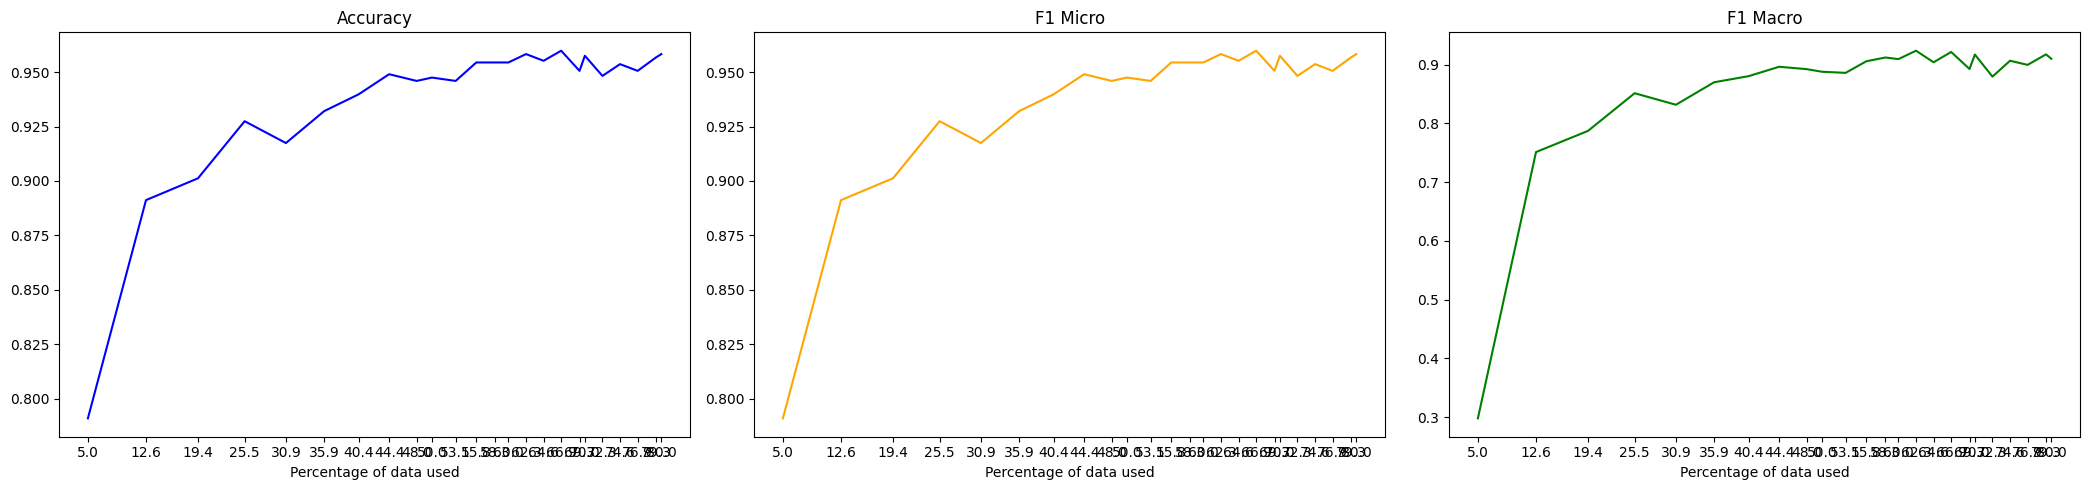

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6456, Accuracy: 0.7865, F1 Micro: 0.8804, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5639, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5346, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5259, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4788, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.477, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 7/10, Train Loss: 0.4707, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4588, Accuracy: 0.7909, F1 Micro: 0.883, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.4215, Accuracy: 0.7932, F1 Micro: 0.8839, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7056, Accuracy: 0.44, F1 Micro: 0.44, F1 Macro: 0.4318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5997, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5241, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5185, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.494, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4806, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4617, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.422, Accuracy: 0.84, F1 Micro: 0.84, F1 Macro: 0.4565
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3873, Accuracy: 0.84, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6159, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5424, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Epoch 3/10, Train Loss: 0.5317, Accuracy: 0.7902, F1 Micro: 0.8825, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.498, Accuracy: 0.7954, F1 Micro: 0.884, F1 Macro: 0.8822
Epoch 5/10, Train Loss: 0.4577, Accuracy: 0.7976, F1 Micro: 0.884, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4142, Accuracy: 0.8073, F1 Micro: 0.8887, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3732, Accuracy: 0.8326, F1 Micro: 0.9016, F1 Macro: 0.8993
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3382, Accuracy: 0.8527, F1 Micro: 0.9124, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2945, Accuracy: 0.8735, F1 Micro: 0.9238, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5607, Accuracy: 0.7437, F1 Micro: 0.7437, F1 Macro: 0.4265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4392, Accuracy: 0.7487, F1 Micro: 0.7487, F1 Macro: 0.4644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3903, Accuracy: 0.7688, F1 Micro: 0.7688, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3015, Accuracy: 0.804, F1 Micro: 0.804, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2422, Accuracy: 0.8442, F1 Micro: 0.8442, F1 Macro: 0.8124
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.8643, F1 Micro: 0.8643, F1 Macro: 0.8294
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.8593, F1 Micro: 0.8593, F1 Macro: 0.8178
Epoch 8/10, Train Loss: 0.145, Accuracy: 0.8593, F1 Micro: 0.8593, F1 Macro: 0.8178
Epoch 9/10, Train Loss: 0.1495, Accuracy: 0.8593, F1 Micro: 0.8593, F1 Macro: 0.8345
Epoch 10/10, Train Loss: 0.0923, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5921, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5076, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4983, Accuracy: 0.7917, F1 Micro: 0.8829, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4466, Accuracy: 0.8006, F1 Micro: 0.8849, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4092, Accuracy: 0.8214, F1 Micro: 0.896, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3639, Accuracy: 0.8557, F1 Micro: 0.9136, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3199, Accuracy: 0.8884, F1 Micro: 0.9319, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2586, Accuracy: 0.9018, F1 Micro: 0.9398, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6172, Accuracy: 0.7362, F1 Micro: 0.7362, F1 Macro: 0.6965
Epoch 2/10, Train Loss: 0.4313, Accuracy: 0.7319, F1 Micro: 0.7319, F1 Macro: 0.7239
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3038, Accuracy: 0.8043, F1 Micro: 0.8043, F1 Macro: 0.792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1839, Accuracy: 0.8681, F1 Micro: 0.8681, F1 Macro: 0.8442
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1964, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1927, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8915
Epoch 7/10, Train Loss: 0.1408, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8768
Epoch 8/10, Train Loss: 0.1018, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8683
Epoch 9/10, Train Loss: 0.0799, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8753
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0.8809, F1 Micro: 0.8809, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5837, Accuracy: 0.785, F1 Micro: 0.8786, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5116, Accuracy: 0.7902, F1 Micro: 0.8823, F1 Macro: 0.8806
Epoch 3/10, Train Loss: 0.4664, Accuracy: 0.7946, F1 Micro: 0.8823, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4455, Accuracy: 0.8185, F1 Micro: 0.8938, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3742, Accuracy: 0.8519, F1 Micro: 0.9109, F1 Macro: 0.9078
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3204, Accuracy: 0.9137, F1 Micro: 0.9466, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.255, Accuracy: 0.9226, F1 Micro: 0.9518, F1 Macro: 0.9487
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1946, Accuracy: 0.9263, F1 Micro: 0.9536, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1628, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.561, Accuracy: 0.7102, F1 Micro: 0.7102, F1 Macro: 0.5364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3298, Accuracy: 0.8694, F1 Micro: 0.8694, F1 Macro: 0.8534
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.8327, F1 Micro: 0.8327, F1 Macro: 0.822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.9083
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8855
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8907
Epoch 8/10, Train Loss: 0.067, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8864
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.8816, F1 Micro: 0.8816, F1 Macro: 0.8641
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8794

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5781, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.493, Accuracy: 0.7954, F1 Micro: 0.8846, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.434, Accuracy: 0.8073, F1 Micro: 0.8886, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3954, Accuracy: 0.8564, F1 Micro: 0.9142, F1 Macro: 0.912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3036, Accuracy: 0.904, F1 Micro: 0.9408, F1 Macro: 0.9372
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2475, Accuracy: 0.9301, F1 Micro: 0.9568, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1837, Accuracy: 0.9345, F1 Micro: 0.959, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1512, Accuracy: 0.9427, F1 Micro: 0.9642, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.595, Accuracy: 0.7399, F1 Micro: 0.7399, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3549, Accuracy: 0.8462, F1 Micro: 0.8462, F1 Macro: 0.8296
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.8755, F1 Micro: 0.8755, F1 Macro: 0.8548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8851
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.8938, F1 Micro: 0.8938, F1 Macro: 0.8765
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.8901, F1 Micro: 0.8901, F1 Macro: 0.875
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.8901, F1 Micro: 0.8901, F1 Macro: 0.8674
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0555, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5632, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4871, Accuracy: 0.8028, F1 Micro: 0.8882, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4399, Accuracy: 0.8244, F1 Micro: 0.8983, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3518, Accuracy: 0.901, F1 Micro: 0.94, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2731, Accuracy: 0.9286, F1 Micro: 0.9554, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2104, Accuracy: 0.9375, F1 Micro: 0.9605, F1 Macro: 0.9569
Epoch 7/10, Train Loss: 0.1538, Accuracy: 0.9353, F1 Micro: 0.9589, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1276, Accuracy: 0.9442, F1 Micro: 0.9647, F1 Macro: 0.9622
Epoch 9/10, Train Loss: 0.1048, Accuracy: 0.9427, F1 Micro: 0.9638, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5623, Accuracy: 0.8111, F1 Micro: 0.8111, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2725, Accuracy: 0.8704, F1 Micro: 0.8704, F1 Macro: 0.8502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8943
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.117, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.909
Epoch 6/10, Train Loss: 0.0792, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8989
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8949
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.9016
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8814
Epoch 10/10, Train Loss: 0.0505, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5573, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4994, Accuracy: 0.7961, F1 Micro: 0.8834, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.435, Accuracy: 0.84, F1 Micro: 0.9039, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3512, Accuracy: 0.9129, F1 Micro: 0.9466, F1 Macro: 0.944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2644, Accuracy: 0.9308, F1 Micro: 0.957, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1926, Accuracy: 0.9338, F1 Micro: 0.9585, F1 Macro: 0.9545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1535, Accuracy: 0.9464, F1 Micro: 0.9662, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1223, Accuracy: 0.9464, F1 Micro: 0.9663, F1 Macro: 0.9631
Epoch 9/10, Train Loss: 0.0986, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5775, Accuracy: 0.8473, F1 Micro: 0.8473, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3012, Accuracy: 0.8855, F1 Micro: 0.8855, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8996
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.096, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8962
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8879
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8908
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.9024
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.899
Epoch 10/10, Train Loss: 0.0444, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5401, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4895, Accuracy: 0.8028, F1 Micro: 0.8865, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4172, Accuracy: 0.8631, F1 Micro: 0.9182, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3267, Accuracy: 0.9249, F1 Micro: 0.9531, F1 Macro: 0.9494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2469, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1699, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9724
Epoch 7/10, Train Loss: 0.1419, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9712
Epoch 8/10, Train Loss: 0.1117, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9695
Epoch 9/10, Train Loss: 0.0889, Accuracy: 0.9487, F1 Micro: 0.9676, F1 Macro: 0.9651
Epoch 10/10, Train L

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5522, Accuracy: 0.8193, F1 Micro: 0.8193, F1 Macro: 0.7851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2872, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9268
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9163
Epoch 5/10, Train Loss: 0.1078, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9142
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9168
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9207
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.93
Epoch 10/10, Train Loss: 0.0585, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9268

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5447, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4698, Accuracy: 0.8036, F1 Micro: 0.8885, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.386, Accuracy: 0.904, F1 Micro: 0.9417, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2862, Accuracy: 0.936, F1 Micro: 0.9601, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2094, Accuracy: 0.9509, F1 Micro: 0.9695, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1478, Accuracy: 0.9516, F1 Micro: 0.9696, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1175, Accuracy: 0.9531, F1 Micro: 0.9706, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0952, Accuracy: 0.9546, F1 Micro: 0.9714, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5353, Accuracy: 0.8627, F1 Micro: 0.8627, F1 Macro: 0.8494
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9219
Epoch 4/10, Train Loss: 0.1396, Accuracy: 0.9255, F1 Micro: 0.9255, F1 Macro: 0.9159
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0936, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9206
Epoch 6/10, Train Loss: 0.0671, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9101
Epoch 7/10, Train Loss: 0.0519, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9201
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9071
Epoch 10/10, Train Loss: 0.0473, Accuracy: 0.9137, F1 Micro: 0.9137, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5518, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.476, Accuracy: 0.8006, F1 Micro: 0.887, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4061, Accuracy: 0.8906, F1 Micro: 0.934, F1 Macro: 0.932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2896, Accuracy: 0.9412, F1 Micro: 0.9637, F1 Macro: 0.9624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2152, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9698
Epoch 6/10, Train Loss: 0.1549, Accuracy: 0.9524, F1 Micro: 0.97, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1346, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9716
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5124, Accuracy: 0.8682, F1 Micro: 0.8682, F1 Macro: 0.847
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2768, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1478, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1155, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0704, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9252
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.913
Epoch 7/10, Train Loss: 0.0465, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8956
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.922
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8997
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.9302, F1 Micro: 0.9302, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5483, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4692, Accuracy: 0.8125, F1 Micro: 0.8918, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3719, Accuracy: 0.9196, F1 Micro: 0.9506, F1 Macro: 0.9485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2639, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.19, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1549, Accuracy: 0.9561, F1 Micro: 0.9724, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1154, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5265, Accuracy: 0.8502, F1 Micro: 0.8502, F1 Macro: 0.8407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9258
Epoch 5/10, Train Loss: 0.095, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0792, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.933
Epoch 7/10, Train Loss: 0.0639, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.9218
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9223
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9171
Epoch 10/10, Train Loss: 0.0396, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5332, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.455, Accuracy: 0.8251, F1 Micro: 0.8984, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3515, Accuracy: 0.9293, F1 Micro: 0.9565, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2478, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1766, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1398, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.478, Accuracy: 0.8523, F1 Micro: 0.8523, F1 Macro: 0.845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1556, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9241
Epoch 4/10, Train Loss: 0.1208, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.921
Epoch 5/10, Train Loss: 0.0809, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9237
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8993
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9205, F1 Micro: 0.9205, F1 Macro: 0.9126
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9091
Epoch 10/10, Train Loss: 0.0606, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9127

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5284, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4629, Accuracy: 0.8289, F1 Micro: 0.9003, F1 Macro: 0.8983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3522, Accuracy: 0.9234, F1 Micro: 0.9525, F1 Macro: 0.9497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2303, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1743, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9732
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9583, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0941, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0648, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5186, Accuracy: 0.8636, F1 Micro: 0.8636, F1 Macro: 0.8506
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.9057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9206
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9018
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.8977, F1 Micro: 0.8977, F1 Macro: 0.8911
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9091
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9326
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9229
Epoch 10/10, Train Loss: 0.0567, Accuracy: 0.9167, F1 Micro: 0.9167, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.516, Accuracy: 0.7946, F1 Micro: 0.8847, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4548, Accuracy: 0.8467, F1 Micro: 0.9092, F1 Macro: 0.9075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3342, Accuracy: 0.9375, F1 Micro: 0.9616, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2305, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9724
Epoch 5/10, Train Loss: 0.1616, Accuracy: 0.9472, F1 Micro: 0.9666, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1244, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.0936, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5144, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9314
Epoch 3/10, Train Loss: 0.1367, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.915
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1014, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.9433
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9269
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9346
Epoch 10/10, Train Loss: 0.0708, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.7924, F1 Micro: 0.8836, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.44, Accuracy: 0.8408, F1 Micro: 0.9065, F1 Macro: 0.9051
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3127, Accuracy: 0.9368, F1 Micro: 0.9609, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2143, Accuracy: 0.9516, F1 Micro: 0.9698, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1558, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0782, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5593, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.284, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1329, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9365
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0963, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9328
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.9392, F1 Micro: 0.9392, F1 Macro: 0.9321
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9354
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9316, F1 Micro: 0.9316, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0685, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9368
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5349, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4412, Accuracy: 0.8363, F1 Micro: 0.9047, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3207, Accuracy: 0.9323, F1 Micro: 0.958, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2296, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.163, Accuracy: 0.9643, F1 Micro: 0.9777, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9778
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5061, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1287, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.953
Epoch 6/10, Train Loss: 0.0747, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9483
Epoch 7/10, Train Loss: 0.0714, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9205
Epoch 8/10, Train Loss: 0.0766, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9248
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9314
Epoch 10/10, Train Loss: 0.0745, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5223, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4424, Accuracy: 0.843, F1 Micro: 0.9081, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2983, Accuracy: 0.9464, F1 Micro: 0.9669, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2031, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9772
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5696, Accuracy: 0.8649, F1 Micro: 0.8649, F1 Macro: 0.8423
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9241
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9575, F1 Micro: 0.9575, F1 Macro: 0.952
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9575, F1 Micro: 0.9575, F1 Macro: 0.9528
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9442
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9186
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.0409, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5206, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4259, Accuracy: 0.8914, F1 Micro: 0.9346, F1 Macro: 0.9333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2842, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1887, Accuracy: 0.965, F1 Micro: 0.9782, F1 Macro: 0.9771
Epoch 5/10, Train Loss: 0.1366, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9759
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.9799
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9805
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.492, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9035
Epoch 2/10, Train Loss: 0.2349, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.905
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1204, Accuracy: 0.9655, F1 Micro: 0.9655, F1 Macro: 0.9611
Epoch 5/10, Train Loss: 0.1122, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9329
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.954, F1 Micro: 0.954, F1 Macro: 0.9489
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9617, F1 Micro: 0.9617, F1 Macro: 0.9574
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.9617, F1 Micro: 0.9617, F1 Macro: 0.9569
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9369
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.9579, F1 Micro: 0.9579, F1 Macro: 0.9524

Sentiment analysis accuracy: 0.9655, F1 Micro: 0.9655,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5218, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4292, Accuracy: 0.8966, F1 Micro: 0.9378, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2839, Accuracy: 0.9472, F1 Micro: 0.9672, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.197, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.9795
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4986, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1385, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9458
Epoch 4/10, Train Loss: 0.1202, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.9224
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9302
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9458
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9446, F1 Micro: 0.9446, F1 Macro: 0.9367
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9061
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0579, Accuracy: 0.9557, F1 Micro: 0.9557, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5235, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4217, Accuracy: 0.9048, F1 Micro: 0.9419, F1 Macro: 0.9398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2726, Accuracy: 0.9539, F1 Micro: 0.9714, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9798
Epoch 9/10, Train Loss: 0.056, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5186, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2371, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1669, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.091, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9442
Epoch 5/10, Train Loss: 0.097, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9171
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.94
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9277
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9345
Epoch 9/10, Train Loss: 0.0645, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Epoch 10/10, Train Loss: 0.0516, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9079

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5183, Accuracy: 0.7946, F1 Micro: 0.8849, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4143, Accuracy: 0.9055, F1 Micro: 0.942, F1 Macro: 0.9393
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2676, Accuracy: 0.9539, F1 Micro: 0.9712, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9799
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9795
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5117, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2271, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.952, F1 Micro: 0.952, F1 Macro: 0.9464
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9331
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9262, F1 Micro: 0.9262, F1 Macro: 0.9186
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9306
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9483, F1 Micro: 0.9483, F1 Macro: 0.9424
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9113
Epoch 10/10, Train Loss: 0.0519, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9299

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5279, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4371, Accuracy: 0.8757, F1 Micro: 0.9263, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2711, Accuracy: 0.9516, F1 Micro: 0.9699, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5249, Accuracy: 0.8855, F1 Micro: 0.8855, F1 Macro: 0.8772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9279
Epoch 4/10, Train Loss: 0.1305, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8949
Epoch 5/10, Train Loss: 0.1044, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9194
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.921
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.918
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9286
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.9048
Epoch 10/10, Train Loss: 0.0542, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.9088

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5216, Accuracy: 0.7932, F1 Micro: 0.8842, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4072, Accuracy: 0.9033, F1 Micro: 0.9417, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2545, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9786
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9673, F1 Micro: 0.9792, F1 Macro: 0.9777
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macro: 0.9782
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4823, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2194, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9318
Epoch 3/10, Train Loss: 0.1797, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1092, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9355
Epoch 5/10, Train Loss: 0.1075, Accuracy: 0.9318, F1 Micro: 0.9318, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0821, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.94
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9242, F1 Micro: 0.9242, F1 Macro: 0.9166
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9448
Epoch 10/10, Train Loss: 0.0567, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5171, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4025, Accuracy: 0.9137, F1 Micro: 0.9471, F1 Macro: 0.9452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2479, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9802
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4593, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9319
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9439
Epoch 4/10, Train Loss: 0.107, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0931, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9486
Epoch 6/10, Train Loss: 0.0715, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9308
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9201
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9401
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9221
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936

Sentiment analysis 

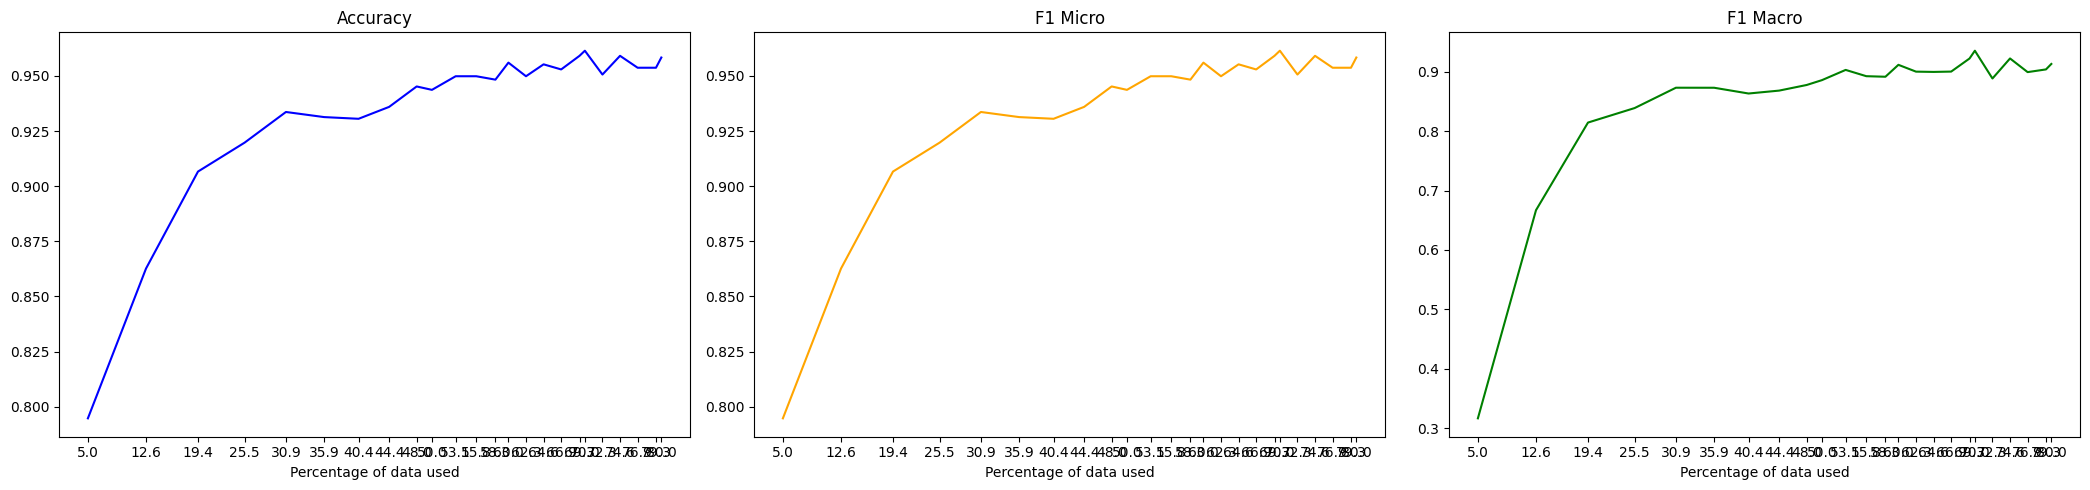

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6298, Accuracy: 0.7522, F1 Micro: 0.854, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5654, Accuracy: 0.7887, F1 Micro: 0.8819, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5262, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4783, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4582, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4326, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4132, Accuracy: 0.7924, F1 Micro: 0.8837, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4395, Accuracy: 0.7939, F1 Micro: 0.8842, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7142, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5719, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6151, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5677, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5123, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5138, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4932, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3579, Accuracy: 0.8065, F1 Micro: 0.8065, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6205, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5585, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5256, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4961, Accuracy: 0.8028, F1 Micro: 0.8881, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.483, Accuracy: 0.8058, F1 Micro: 0.8897, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4131, Accuracy: 0.814, F1 Micro: 0.8935, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3886, Accuracy: 0.8266, F1 Micro: 0.8994, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3387, Accuracy: 0.8438, F1 Micro: 0.9077, F1 Macro: 0.9055
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.551, Accuracy: 0.7701, F1 Micro: 0.7701, F1 Macro: 0.4351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4534, Accuracy: 0.7701, F1 Micro: 0.7701, F1 Macro: 0.4351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4111, Accuracy: 0.7701, F1 Micro: 0.7701, F1 Macro: 0.4351
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3035, Accuracy: 0.7816, F1 Micro: 0.7816, F1 Macro: 0.4855
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2234, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1284, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9058
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8818
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8902
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.595, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5147, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4887, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4587, Accuracy: 0.8058, F1 Micro: 0.89, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4261, Accuracy: 0.8207, F1 Micro: 0.8968, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3735, Accuracy: 0.8438, F1 Micro: 0.9082, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2986, Accuracy: 0.8862, F1 Micro: 0.9316, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2613, Accuracy: 0.907, F1 Micro: 0.9428, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6172, Accuracy: 0.7022, F1 Micro: 0.7022, F1 Macro: 0.4125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4545, Accuracy: 0.8267, F1 Micro: 0.8267, F1 Macro: 0.8043
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3328, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.203, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.9026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9108
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9088
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.9003
Epoch 8/10, Train Loss: 0.1046, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1107, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.9122
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5744, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 2/10, Train Loss: 0.5009, Accuracy: 0.7894, F1 Micro: 0.8804, F1 Macro: 0.8777
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4685, Accuracy: 0.8028, F1 Micro: 0.8878, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4321, Accuracy: 0.814, F1 Micro: 0.8921, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3679, Accuracy: 0.8542, F1 Micro: 0.9132, F1 Macro: 0.9108
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2984, Accuracy: 0.8981, F1 Micro: 0.9365, F1 Macro: 0.9314
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2436, Accuracy: 0.9174, F1 Micro: 0.9488, F1 Macro: 0.9454
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1861, Accuracy: 0.9315, F1 Micro: 0.9575, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1476, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6142, Accuracy: 0.7068, F1 Micro: 0.7068, F1 Macro: 0.4141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4114, Accuracy: 0.8797, F1 Micro: 0.8797, F1 Macro: 0.8549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.226, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1025, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1443, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9165
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.903
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9361, F1 Micro: 0.9361, F1 Macro: 0.9232
Epoch 9/10, Train Loss: 0.1134, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9154
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5899, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5165, Accuracy: 0.7946, F1 Micro: 0.8834, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4603, Accuracy: 0.8095, F1 Micro: 0.89, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.41, Accuracy: 0.8586, F1 Micro: 0.917, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.318, Accuracy: 0.9115, F1 Micro: 0.9447, F1 Macro: 0.9407
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2452, Accuracy: 0.9219, F1 Micro: 0.9507, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1849, Accuracy: 0.9353, F1 Micro: 0.9591, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1447, Accuracy: 0.9435, F1 Micro: 0.9645, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6263, Accuracy: 0.6873, F1 Micro: 0.6873, F1 Macro: 0.4073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4418, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.8568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2793, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9422
Epoch 5/10, Train Loss: 0.1369, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9225
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9217
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.9072
Epoch 8/10, Train Loss: 0.1162, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9221
Epoch 9/10, Train Loss: 0.109, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.918
Epoch 10/10, Train Loss: 0.0617, Accuracy: 0.9305, F1 Micro: 0.9305, F1 Macro: 0.9221

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5583, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5122, Accuracy: 0.7999, F1 Micro: 0.8863, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4483, Accuracy: 0.8229, F1 Micro: 0.8963, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3585, Accuracy: 0.8884, F1 Micro: 0.9325, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2664, Accuracy: 0.9256, F1 Micro: 0.9539, F1 Macro: 0.9504
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2052, Accuracy: 0.9531, F1 Micro: 0.9709, F1 Macro: 0.9696
Epoch 7/10, Train Loss: 0.1569, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9681
Epoch 8/10, Train Loss: 0.1272, Accuracy: 0.9501, F1 Micro: 0.9686, F1 Macro: 0.9662
Epoch 9/10, Train Loss: 0.0992, Accuracy: 0.9531, F1 Micro: 0.9705, F1 Macro: 0.9685
Higher F1 achieved, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5854, Accuracy: 0.6834, F1 Micro: 0.6834, F1 Macro: 0.406
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4026, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.191, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9185
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8993
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9025
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9053
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9344, F1 Micro: 0.9344, F1 Macro: 0.9262
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9139
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9185
Epoch 10/10, Train Loss: 0.0642, Accuracy: 0.9266, F1 Micro: 0.9266, F1 Macro: 0.9185

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5568, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5212, Accuracy: 0.8043, F1 Micro: 0.8885, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4344, Accuracy: 0.8668, F1 Micro: 0.9215, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3155, Accuracy: 0.9263, F1 Micro: 0.9546, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2295, Accuracy: 0.9405, F1 Micro: 0.9625, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1677, Accuracy: 0.9509, F1 Micro: 0.9692, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1368, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9711
Epoch 8/10, Train Loss: 0.1081, Accuracy: 0.9554, F1 Micro: 0.972, F1 Macro: 0.9701
Epoch 9/10, Train Loss: 0.089, Accuracy: 0.9509, F1 Micro: 0.9689, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5756, Accuracy: 0.6962, F1 Micro: 0.6962, F1 Macro: 0.4828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3281, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9155
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1275, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9245
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9109
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1193, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9305
Epoch 8/10, Train Loss: 0.0946, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9115
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9209
Epoch 10/10, Train Loss: 0.0493, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5464, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4781, Accuracy: 0.808, F1 Micro: 0.8912, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4095, Accuracy: 0.881, F1 Micro: 0.9288, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3016, Accuracy: 0.9263, F1 Micro: 0.9542, F1 Macro: 0.952
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2229, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0938, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5622, Accuracy: 0.6769, F1 Micro: 0.6769, F1 Macro: 0.4037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3184, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.158, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9119
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1427, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9218
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0917, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9272
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9084
Epoch 10/10, Train Loss: 0.0735, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5408, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4878, Accuracy: 0.8251, F1 Micro: 0.8997, F1 Macro: 0.8984
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3716, Accuracy: 0.9077, F1 Micro: 0.944, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2628, Accuracy: 0.9397, F1 Micro: 0.9623, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1843, Accuracy: 0.9494, F1 Micro: 0.9684, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9713
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9546, F1 Micro: 0.9713, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0757, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5355, Accuracy: 0.8599, F1 Micro: 0.8599, F1 Macro: 0.8292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9177
Epoch 5/10, Train Loss: 0.1047, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8979
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9297
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9385
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9339, F1 Micro: 0.9339, F1 Macro: 0.9241
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5503, Accuracy: 0.7961, F1 Micro: 0.8849, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4798, Accuracy: 0.8125, F1 Micro: 0.8933, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3821, Accuracy: 0.9107, F1 Micro: 0.9457, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2674, Accuracy: 0.9412, F1 Micro: 0.9632, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1886, Accuracy: 0.9554, F1 Micro: 0.9722, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.9568, F1 Micro: 0.9729, F1 Macro: 0.9713
Epoch 7/10, Train Loss: 0.1193, Accuracy: 0.9531, F1 Micro: 0.9704, F1 Macro: 0.9679
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9561, F1 Micro: 0.9722, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5882, Accuracy: 0.8008, F1 Micro: 0.8008, F1 Macro: 0.725
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2773, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1734, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1552, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9261
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9121
Epoch 6/10, Train Loss: 0.1119, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9174
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9105
Epoch 8/10, Train Loss: 0.1039, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9035
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.922
Epoch 10/10, Train Loss: 0.053, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9112

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5388, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4722, Accuracy: 0.8318, F1 Micro: 0.9031, F1 Macro: 0.902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3693, Accuracy: 0.91, F1 Micro: 0.9451, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2451, Accuracy: 0.942, F1 Micro: 0.9639, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1735, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1382, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9576, F1 Micro: 0.9733, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9658, F1 Micro: 0.9786, F1 Macro: 0.9775
Epoch 9/10, Train Loss: 0.0693, Accuracy: 0.9591, F1 Micro: 0.9741, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.8725, F1 Micro: 0.8725, F1 Macro: 0.86
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2708, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9339
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.937
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9482, F1 Micro: 0.9482, F1 Macro: 0.942
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9402, F1 Micro: 0.9402, F1 Macro: 0.9327
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9262
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9377
Epoch 10/10, Train Loss: 0.0532, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5435, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4614, Accuracy: 0.8393, F1 Micro: 0.9072, F1 Macro: 0.9061
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3401, Accuracy: 0.9293, F1 Micro: 0.9565, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2411, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4993, Accuracy: 0.8824, F1 Micro: 0.8824, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9047
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9451, F1 Micro: 0.9451, F1 Macro: 0.9386
Epoch 4/10, Train Loss: 0.1295, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.915
Epoch 5/10, Train Loss: 0.1506, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8954
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8993
Epoch 7/10, Train Loss: 0.1241, Accuracy: 0.9333, F1 Micro: 0.9333, F1 Macro: 0.9265
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.906
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.9412, F1 Micro: 0.9412, F1 Macro: 0.9348
Epoch 10/10, Train Loss: 0.0508, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9219

Sentiment analysis accuracy: 0.9451, F1 Micro: 0.9451

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4601, Accuracy: 0.8289, F1 Micro: 0.9007, F1 Macro: 0.8992
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3469, Accuracy: 0.9405, F1 Micro: 0.9632, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2305, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5171, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2611, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.9353
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9382, F1 Micro: 0.9382, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.129, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9421, F1 Micro: 0.9421, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9498, F1 Micro: 0.9498, F1 Macro: 0.9439
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9481
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9459, F1 Micro: 0.9459, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9537, F1 Micro: 0.9537, F1 Macro: 0.9475
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5367, Accuracy: 0.8006, F1 Micro: 0.887, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4586, Accuracy: 0.84, F1 Micro: 0.9071, F1 Macro: 0.9062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.329, Accuracy: 0.9397, F1 Micro: 0.9629, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2203, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9738
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.979
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9737
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Epoch 10/10, Train Loss: 0.052, Accuracy: 0.9658, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.551, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2113, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.9508, F1 Micro: 0.9508, F1 Macro: 0.9464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9493
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.959, F1 Micro: 0.959, F1 Macro: 0.9549
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9631, F1 Micro: 0.9631, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9672, F1 Micro: 0.9672, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9672, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5359, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4373, Accuracy: 0.8683, F1 Micro: 0.9221, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.298, Accuracy: 0.9457, F1 Micro: 0.9659, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9768
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5399, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2708, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9609, F1 Micro: 0.9609, F1 Macro: 0.9562
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9391
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9475
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9531, F1 Micro: 0.9531, F1 Macro: 0.9478
Epoch 7/10, Train Loss: 0.0912, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9436
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.938
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9233
Epoch 10/10, Train Loss: 0.0472, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9233

Sentiment analysis accuracy: 0.9609, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5322, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4511, Accuracy: 0.8594, F1 Micro: 0.9177, F1 Macro: 0.9176
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.306, Accuracy: 0.9397, F1 Micro: 0.9628, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2065, Accuracy: 0.9531, F1 Micro: 0.9707, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9613, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.533, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2676, Accuracy: 0.9297, F1 Micro: 0.9297, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9349
Epoch 5/10, Train Loss: 0.1095, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9311
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9307
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9345
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9258
Epoch 10/10, Train Loss: 0.0641, Accuracy: 0.9297, F1 Micro: 0.9297, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5491, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4431, Accuracy: 0.8772, F1 Micro: 0.9266, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2909, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.192, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.112, Accuracy: 0.9591, F1 Micro: 0.974, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0847, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9786
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9784
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4726, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.8794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9429
Epoch 7/10, Train Loss: 0.0928, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.927
Epoch 9/10, Train Loss: 0.068, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9391
Epoch 10/10, Train Loss: 0.0484, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5291, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.426, Accuracy: 0.8906, F1 Micro: 0.9349, F1 Macro: 0.9342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2829, Accuracy: 0.9509, F1 Micro: 0.9694, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9561, F1 Micro: 0.9726, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.976

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5626, Accuracy: 0.8906, F1 Micro: 0.8906, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2999, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.93
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9439
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9111
Epoch 6/10, Train Loss: 0.1322, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9356
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9394
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9356
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Epoch 10/10, Train Loss: 0.0676, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9345

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5188, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4271, Accuracy: 0.8958, F1 Micro: 0.9373, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2916, Accuracy: 0.9457, F1 Micro: 0.9662, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.9591, F1 Micro: 0.9745, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9785
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8912
Epoch 2/10, Train Loss: 0.3023, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9218
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9305
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9276
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.928
Epoch 8/10, Train Loss: 0.0746, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9068
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.907
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8991

Sentiment analysis accuracy: 0.9385, F1 Micro: 0.9385, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.7984, F1 Micro: 0.8868, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4283, Accuracy: 0.8876, F1 Micro: 0.9329, F1 Macro: 0.9324
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2773, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9785
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.056, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5038, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.895
Epoch 2/10, Train Loss: 0.2833, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.9466, F1 Micro: 0.9466, F1 Macro: 0.9401
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9226
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9389, F1 Micro: 0.9389, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0575, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5327, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.417, Accuracy: 0.9077, F1 Micro: 0.9441, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.263, Accuracy: 0.9509, F1 Micro: 0.9697, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.9726
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4722, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8917
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2341, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9269
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.921
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.901
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1062, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9269
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9196
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9314
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9151
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5293, Accuracy: 0.7939, F1 Micro: 0.8809, F1 Macro: 0.8763
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4053, Accuracy: 0.9196, F1 Micro: 0.9513, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2562, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1706, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1249, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9742
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5123, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2636, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.9111
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1873, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9349
Epoch 4/10, Train Loss: 0.1372, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0873, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9436
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9311
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9414, F1 Micro: 0.9414, F1 Macro: 0.9352
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9188
Epoch 10/10, Train Loss: 0.0449, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5252, Accuracy: 0.7969, F1 Micro: 0.886, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4134, Accuracy: 0.9211, F1 Micro: 0.9523, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2573, Accuracy: 0.9546, F1 Micro: 0.972, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9621, F1 Micro: 0.9763, F1 Macro: 0.9752
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9598, F1 Micro: 0.9747, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9688, F1 Micro: 0.9805, F1 Macro: 0.9794
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9764
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0.9613, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4608, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2322, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9376
Epoch 3/10, Train Loss: 0.1437, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9252
Epoch 4/10, Train Loss: 0.0975, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0936, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9365
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9415
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9433, F1 Micro: 0.9433, F1 Macro: 0.9376
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9322
Epoch 10/10, Train Loss: 0.0576, Accuracy: 0.9393, F1 Micro: 0.9393, F1 Macro: 0.9309

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5219, Accuracy: 0.7976, F1 Micro: 0.8864, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4004, Accuracy: 0.9204, F1 Micro: 0.9511, F1 Macro: 0.9496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2457, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1222, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9773
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9734
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9635, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4917, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2277, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9393
Epoch 3/10, Train Loss: 0.1384, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9201
Epoch 4/10, Train Loss: 0.1135, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9197
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9168
Epoch 6/10, Train Loss: 0.0698, Accuracy: 0.9394, F1 Micro: 0.9394, F1 Macro: 0.9318
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.895
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9432, F1 Micro: 0.9432, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.947, F1 Micro: 0.947, F1 Macro: 0.9403
Epoch 10/10, Train Loss: 0.0497, Accuracy: 0.9356, F1 Micro: 0.9356, F1 Macro: 0.926

Sentiment analysis accuracy: 0.947, F1 Micro: 0.947, F1 Macro:

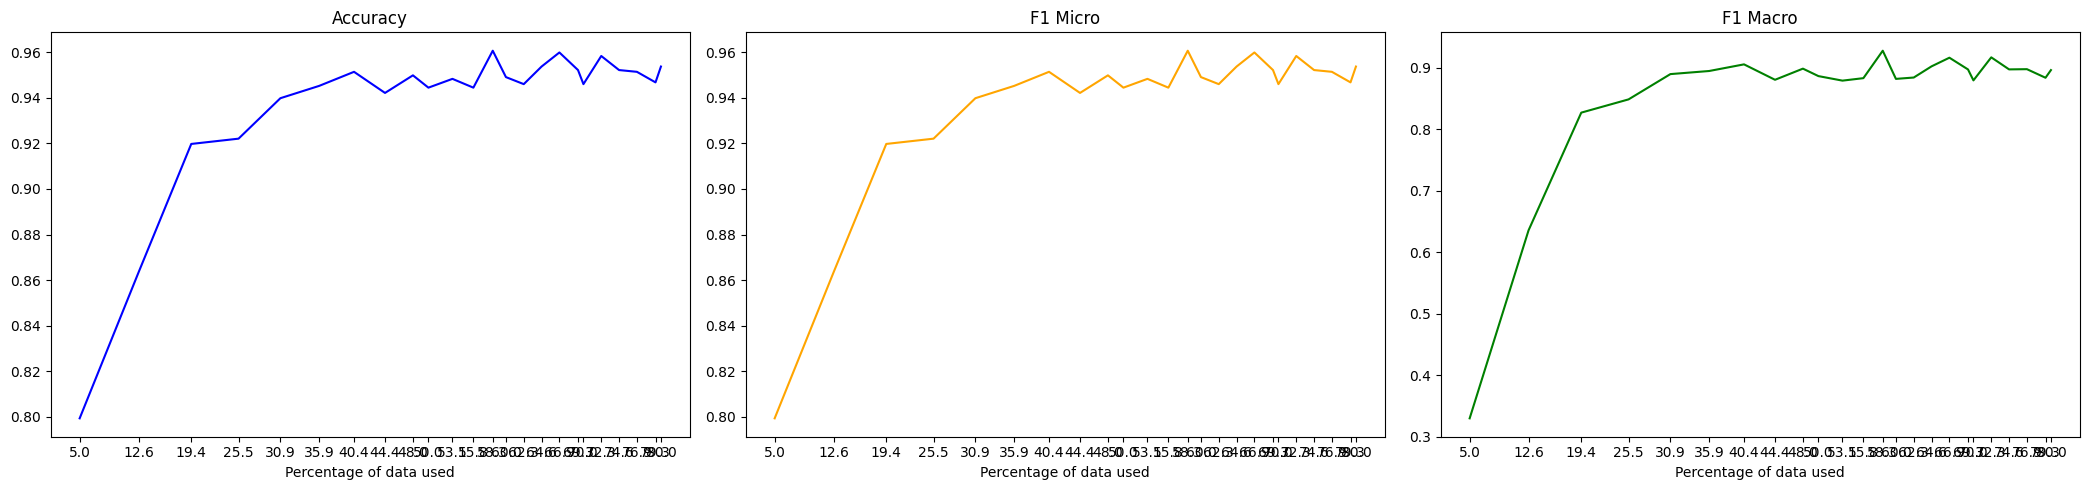

In [ ]:
active_learning(seeds[4], 4)